# 環境の設定

In [1]:
from blindcliftwalk import BlindCliftwalk

# ゴールまでの距離
nb_step = 20
#nb_step = 10

# ゴールの数
nb_goals = 3
#nb_goals = 1

env = BlindCliftwalk(nb_step, nb_goals)

In [2]:
import numpy as np

np.random.seed(seed=50)
env.set_ground_truth()
env.ground_truth

array([[2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

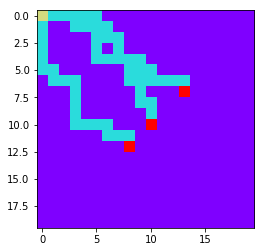

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(env.ground_truth, 'rainbow', interpolation='nearest')
#plt.savefig('ground_truth.png')

# 方策勾配法（REINFORCEアルゴリズム）で方策を学習する

- ニューラルネット型の方策を使用する。

In [4]:
import tensorflow as tf

t_action = tf.placeholder(tf.float32, [None, 2], name='action')
t_state = tf.placeholder(tf.float32, [None, 2], name='state')
t_reward = tf.placeholder(tf.float32, [None, ], name='reward')

#model = 'two_layers'
model = 'three_layers'

sess = tf.InteractiveSession()
#state_scale = 1./20.
state_scale = 1.

if model=='two_layers':
    nb_nodes = 20
    
    W1 = tf.Variable(tf.random_normal([2, nb_nodes], stddev=np.sqrt(2. / float(2 + nb_nodes))), name='W1')
    W2 = tf.Variable(tf.random_normal([nb_nodes, 2], stddev=np.sqrt(2. / float(nb_nodes + 2))), name='W2')
    b1 = tf.Variable(tf.random_normal([nb_nodes]), name='b1')
    b2 = tf.Variable(tf.random_normal([2]), name='b2')
    
    h1 = tf.nn.relu(tf.nn.bias_add(tf.matmul(t_state, W1),b1))
    t_policy = tf.nn.softmax(tf.nn.bias_add(tf.matmul(h1, W2),b2))
#    h1 = tf.nn.relu(tf.contrib.layers.batch_norm(tf.nn.bias_add(tf.matmul(t_state, W1),b1)))
#    t_policy = tf.nn.softmax(tf.contrib.layers.batch_norm(tf.nn.bias_add(tf.matmul(h1, W2),b2)))
    
elif model=='three_layers':
    nb_nodes1 = 20
    nb_nodes2 = 20
    
    W1 = tf.Variable(tf.random_normal([2, nb_nodes1], stddev=np.sqrt(2. / float(2 + nb_nodes1))), name='W1')
    W2 = tf.Variable(tf.random_normal([nb_nodes1, nb_nodes2], stddev=np.sqrt(2. / float(nb_nodes1 + nb_nodes2))), name='W2')
    W3 = tf.Variable(tf.random_normal([nb_nodes2, 2], stddev=np.sqrt(2. / float(nb_nodes2 + 2))), name='W3')
    b1 = tf.Variable(tf.random_normal([nb_nodes1]), name='b1')
    b2 = tf.Variable(tf.random_normal([nb_nodes2]), name='b2')
    b3 = tf.Variable(tf.random_normal([2]), name='b3')
    
    h1 = tf.nn.relu(tf.nn.bias_add(tf.matmul(t_state, W1),b1))
    h2 = tf.nn.relu(tf.nn.bias_add(tf.matmul(h1, W2),b2))
    t_policy = tf.nn.softmax(tf.nn.bias_add(tf.matmul(h2, W3),b3))

'''
p(a=a*|s) = <p(a|s), a*>
ただし、a*はone-hotベクトル
'''
t_score = tf.reduce_sum(t_policy * t_action, -1)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)

'''
方策勾配法では損失関数ではなく方策の良さを目的関数にしているので、
パラメータの更新方向は勾配方向と同じ（損失関数を使った場合と逆向き）
'''
grads_and_vars = optimizer.compute_gradients(-t_reward * t_score)

train_step = optimizer.apply_gradients(grads_and_vars)
tf.global_variables_initializer().run()

/Users/ruhokondo/Programming/anaconda3/envs/dl35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/ruhokondo/Programming/anaconda3/envs/dl35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
#  エポック数。全エピソード数は nb_epoch * nb_mc になる。
nb_epoch = 1000

# MC計算に使うepisode数。パラメータ更新回数は　nb_episode　/　nb_mc　になる
nb_mc = 100

# ゴール到達後のstate valueの保存間隔
save_interval = 100

# ε-greedyのハイパーパラメータ
epsilon = .1

In [6]:
def gumbel_sampling(prob):
    rand = np.random.random(len(prob))
    g = -np.log(-np.log(rand))
    return np.argmax(g+np.log(prob))

def epsilon_greedy(sess, t_policy, state, env, epsilon):
    if np.random.random(1) > epsilon:
        action_prob = t_policy.eval({t_state:np.expand_dims(np.array(state) * state_scale,0)}, sess)[0]# + np.finfo(np.float32).eps
    else:
        action_prob = np.random.random(2)
    action_prob = action_prob / action_prob.sum()
    action = np.eye(2)[gumbel_sampling(action_prob)].astype(int)
    return action_prob, action

In [7]:
def get_trajectory(sess, env, nb_try=100):
    trajectory = np.zeros_like(env.ground_truth).astype(np.float32)

    for _ in range(nb_try):
        current_state = [0,0]
        status = 1
        while status>=0:

                # policyにしたがって行動を取る（まだ遷移させない）。εはゼロにしておく。
                action_prob, action = epsilon_greedy(sess, t_policy, current_state, env, 0.)

                # 行動に対する報酬と遷移後の状態の計算
                next_state, reward, status = env.do_action(current_state, action)

                # トラジェクトリの記録
                trajectory[current_state[0],current_state[1]] += 1.

                # 状態の遷移（マス目の移動）
                current_state = next_state
    return trajectory

def get_probability_distribution(env, sess):
    learnt_policy = np.expand_dims(np.zeros_like(env.ground_truth).astype(np.float32), -1)
    learnt_policy = np.concatenate([learnt_policy,learnt_policy,learnt_policy],-1)
    for s0 in range(env.ground_truth.shape[0]):
        for s1 in range(env.ground_truth.shape[1]):
            state = np.array([s0,s1]).astype(np.float32)
            policy = t_policy.eval({t_state: np.expand_dims(state,0)}, sess)[0]
            
            # Rチャンネルにdownの確率、Bチャンネルにrightの確率
            learnt_policy[s0,s1,0] = policy[0]
            learnt_policy[s0,s1,2] = policy[1]
    return learnt_policy

  0%|          | 0/1000 [00:00<?, ?it/s]

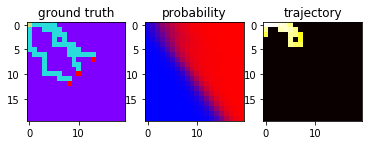

 10%|█         | 100/1000 [00:16<02:32,  5.89it/s]

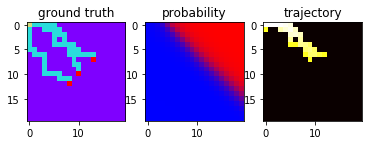

 20%|██        | 200/1000 [00:39<02:38,  5.05it/s]

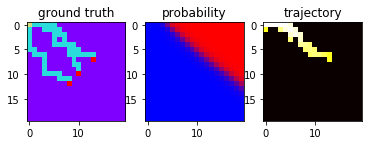

 30%|███       | 300/1000 [01:03<02:28,  4.71it/s]

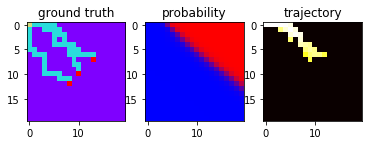

 40%|████      | 400/1000 [01:29<02:14,  4.46it/s]

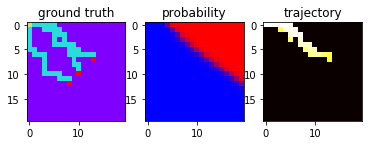

 50%|█████     | 500/1000 [01:57<01:57,  4.24it/s]

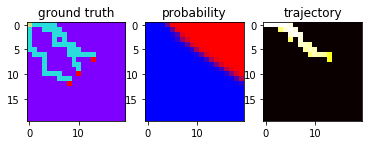

 60%|██████    | 600/1000 [02:28<01:39,  4.03it/s]

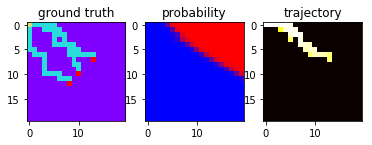

 70%|███████   | 700/1000 [03:00<01:17,  3.88it/s]

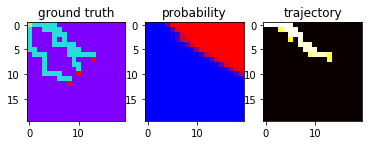

 80%|████████  | 800/1000 [03:36<00:54,  3.69it/s]

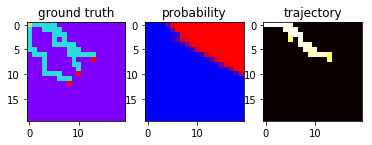

 90%|█████████ | 900/1000 [04:12<00:28,  3.56it/s]

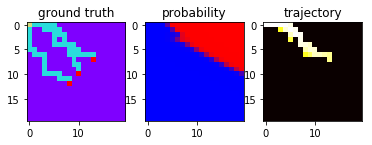

100%|██████████| 1000/1000 [04:48<00:00,  3.47it/s]


In [8]:
from tqdm import tqdm
import copy

isSuccessed = False

temp = []
count = 0
success_history = []
for epoch in tqdm(range(int(nb_epoch))):
    
    # ε-greedyのεを減衰させる
    epsilon = epsilon * 0.999
    
    episode_states = []
    episode_actions = []
    episode_rewards = []
    success_count = 0
    if not epoch%save_interval:
        plt.subplot(1,3,1)
        plt.imshow(env.ground_truth, 'rainbow', interpolation='nearest')
        plt.title('ground truth')
        plt.subplot(1,3,2)
        plt.imshow(get_probability_distribution(env, sess), 'bwr', interpolation='nearest')
        plt.title('probability')
        plt.subplot(1,3,3)
        plt.imshow(np.log(get_trajectory(sess, env)+np.finfo(np.float32).eps), 'hot')
        plt.title('trajectory')
        plt.show()
#        print()
    for mc_step in range(nb_mc):
        # 状態の初期化（スタート地点に戻る）
        current_state  = np.zeros(2, dtype=int)
    
        status = 0
        while status >= 0:
            # policyにしたがって行動を取る（まだ遷移させない）
            action_prob, action = epsilon_greedy(sess, t_policy, current_state, env, epsilon)

            # 行動に対する報酬と遷移後の状態の計算
            next_state, reward, status = env.do_action(current_state, action)
#            if status==0:
#                reward=1#test
#            if status==1:
#                reward=10#test
            if status==-1:
                reward=-1#test
#                reward=-0.1#test
                
            if not epoch%save_interval and mc_step==0:
                pass
#                print('s=',current_state,' p=',action_prob,' a=',action,' status=',status)
            
            # エピソード中の遷移前状態、行動、報酬を保存する
            episode_states.append(copy.deepcopy(current_state))
            episode_actions.append(copy.deepcopy(action))
            episode_rewards.append(copy.deepcopy(reward))

            # 状態の遷移（マス目の移動）
            current_state = next_state
            
            if status==1:
                success_count += 1
                isSuccessed = True

    # 方策勾配を計算する
    episode_states = np.array(episode_states)
    episode_actions = np.array(episode_actions)
    episode_rewards = np.array(episode_rewards)
    success_history.append(success_count)
    sess.run(
        [train_step], 
        feed_dict={
            t_action: episode_actions,
#            t_state: episode_states,
            t_state: episode_states * state_scale,
            t_reward: episode_rewards
        }
    )

Text(0,0.5,'success count / epoch')

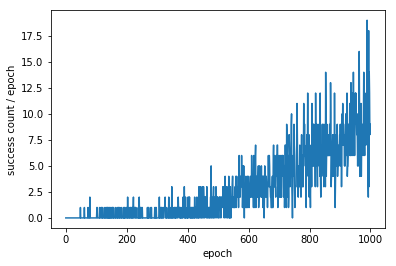

In [9]:
plt.plot(success_history)
plt.xlabel('epoch')
plt.ylabel('success count / epoch')